<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #7: Ranking

<span style="color:blue; font-size: 12pt">Anastasia Zukhba </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:

[1] C.J.C. Burges, T. Shaked, E. Renshaw, A. Lazier, M. Deeds, N. Hamilton and G. Hullender. Learning to rank using gradient descent. In Proc. of ICML, pages 89-96, 2005.

[2] Y. Freund, R. Iyer, R. Schapire, and Y. Singer. An efficient boosting algorithm for combining preferences. The Journal of Machine Learning Research, 4: 933-969, 2003.

[3] J. Xu and H. Li. AdaRank: a boosting algorithm for information retrieval. In Proc. of SIGIR, pages 391-398, 2007.

[4] D. Metzler and W.B. Croft. Linear feature-based models for information retrieval. Information Retrieval, 10(3): 257-274, 2007.

[5] Q. Wu, C.J.C. Burges, K. Svore and J. Gao. Adapting Boosting for Information Retrieval Measures. Journal of Information Retrieval, 2007.

[6] J.H. Friedman. Greedy function approximation: A gradient boosting machine. Technical Report, IMS Reitz Lecture, Stanford, 1999; see also Annals of Statistics, 2001.

[7] Z. Cao, T. Qin, T.Y. Liu, M. Tsai and H. Li. Learning to Rank: From Pairwise Approach to Listwise Approach. ICML 2007. 

[8] L. Breiman. Random Forests. Machine Learning 45 (1): 5–32, 2001.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было.

<h1 align="center">Check Questions (10%)</h1> 

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

Есть множество объектов, наша задача состоит в том, чтобы построить функцию так, чтобы она задавала правильный порядок на этих объектах. 

Для задачи ранжирования поисковой выдачи у нас есть множество документов $D$ и есть множество запросов $Q$, объектами для данной задачи являются пары $x=(q, d)$, $q$ - это запрос, $d$ - документ. Наша задача для очередной пары $(q, d)$ сказать, насколько документ $d$ релевантен запросу $q$. Изначальную оценку релевантности мы получаем из оценок асессоров. Сравнивать мы можем документы, которые были выданы по одному запросу.    

**2.** В чём преимущество метрики NDCG перед метрикой MAP?

Метрика $MAP$ предполагает, что для пары документ-запрос есть всего две оценки - либо документ релевантен запросу, либо нет, то есть $Y = \{ 0, 1 \}$, $NDCG$ позволяет учитывать степень релевантности дакумента запросу, а также позицию документа в результатах запроса

**3.** Почему говорят, что все основные метрики качества дискретны?

Метрики качества зависят от релевантности (оценики асессора) и некоторые от порядка, поскольку и то и другое - величины дискретные, то метрики качества также получаются дискретными 

<h1 align="center"> Theoretical tasks (10%)</h1>

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

**3.** Пользователь браузера в дополнение к кликам по ссылкам один раз может перейти по кнопке *Назад* и вернуться на предыдущую страницу. Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

<h1 align="center"> Practical tasks (80%)</h1>
# Part 1 (15%)

In [23]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rc('text', usetex=False)
plt.rc('text.latex', unicode=True)
plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
plt.rc('font', family='serif', size='16')

## Вычисление весов PageRank power-методом.

Реализовать удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [120]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links = np.array(links)
    if N is None:
        N = links.max() + 1
    
    prob_matrix = np.zeros((N, N))
    for edge in links:
        prob_matrix[edge[0]][edge[1]] = 1
        
    for j in range(N):
        prob_matrix[:,j] = prob_matrix[:,j] / prob_matrix[:,j].sum()
    np.set_printoptions(precision=3)
    
    prob_matrix = np.nan_to_num(prob_matrix)
    
    return prob_matrix


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    prob_matrix = create_page_rank_markov_chain(links, 
                                                damping_factor=damping_factor, N=len(start_distribution[0]))
    distribution = np.matrix(start_distribution)
    
    N = len(start_distribution[0])
    trace = []
    trace.append(distribution)
    while (True):
        prev_dist = distribution
        distribution = np.dot((1 - damping_factor) / N * np.ones((N, N)) + damping_factor * prob_matrix, prev_dist.T).T
        trace.append(distribution)

        if (np.sum((distribution - prev_dist.T)**2) < tolerance):
            break
    
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

# Проверка реализации
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [121]:
def random_graph(n, p):
    rand_graph = []
    
    for vert_out in range(n):
        for vert_in in range(n):
            if (vert_in != vert_out and np.random.choice([1, 0], p=[p, 1-p]) == 1):
                rand_graph.append((vert_out, vert_in))
    
    return rand_graph

Теперь сгенерируем случайный граф и нарисуем его.

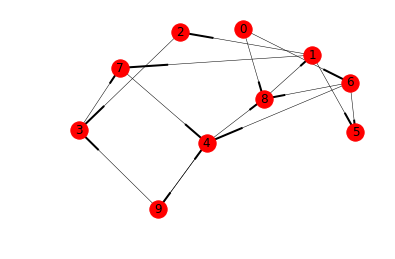

In [122]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


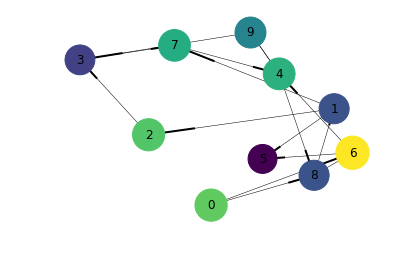

In [123]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

##### Эргодическая теорема:
$$D(p) = \frac{1}{2}sup_{i, k} ||\space p(i) - p(k) \space||$$
$$||\space \pi_0P^n - \pi \space|| \leq D(p)^n||\space \pi_0 - \pi \space||$$

In [124]:
def estimation(errors, distribution):
    max_ = 0.
    for p_first in distribution:
        for p_second in distribution:
            if (abs(p_first - p_second) > max_):
                max_ = abs(p_first - p_second)
    D_p = 1 / 2 * max_

    return [(D_p**i)*errors[i] for i in range(len(errors))]

In [125]:
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))
x = np.arange(len(errors))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


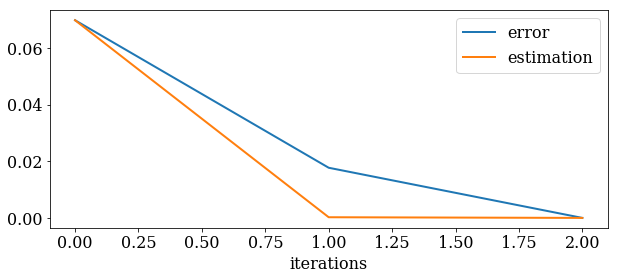

In [126]:
plt.figure(figsize=(10, 4))

plt.plot(x, errors, lw=2, label='error')
plt.plot(x, estimation(errors, pr_distribution), 
         lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

* Эргодическая теорема даёт достаточно точную оценку на сходимость

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

Отрисовывает вершины графа с весами в зависимости от их page rank

In [149]:
def render_graph_with_weight(graph, vert_weights):
    size_const = 10 ** 4
    plt.axis('off')
    plt.title("Vertex number = " + str(len(vert_weights)))
    networkx.draw_networkx(graph, width=0.2, node_size=size_const * vert_weights, 
                           node_color=vert_weights)
    plt.figure(figsize=(5, 5))

График количество итераций от количества вершин в графе

In [193]:
def render_result_vert_num(iterations_num, vertex_number, edge_probability):
    plt.figure(figsize=(7, 5))
    plt.plot(vertex_number, iterations_num, lw=2, label="Train")
    plt.xlabel('vertex_number')
    plt.ylabel('iteration')
    plt.title('Iterations (vertex number), edge prob:' + str(edge_probability))
    plt.legend(loc=2)
    plt.grid()
    plt.show()

График количество итераций от вероятности ребра

In [194]:
def render_result_edge_prop(iterations_num, vertex_number, edge_probability):
    plt.figure(figsize=(7, 5))
    plt.plot(edge_probability, iterations_num, lw=2, label="Train")
    plt.xlabel('edge_probability')
    plt.ylabel('iterations_num')
    plt.title('Iterations (edge probability), vertex number is:' + str(vertex_number))
    plt.legend(loc=2)
    plt.grid()
    plt.show()

Создаёт граф с количеством вершин v_number и вероятностью ребра prob, находит pagerank для каждой вершины, отрисовывает граф в зависимости от pr

In [224]:
def start_research(v_number, prob, exception_flag=False):
    start_distribution = np.ones((1, v_number)) / v_number
    edges = random_graph(v_number, prob)

    G = networkx.DiGraph()
    G.add_edges_from(edges)

    pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                              return_trace=True)
    
    # чтобы не рисовать очень много графов
    if ((v_number < 17 and prob < 0.6 and v_number % 2 == 0) or exception_flag):
        render_graph_with_weight(G, pr_distribution)
        
    return len(pr_trace)

Создадим начальное множество вершин и вероятностей рёбер

In [252]:
vert_number = [i for i in range(10, 50)]
edge_probability = np.linspace(0, 1, 10)[1:-1]

Проанализируем количество итераций в зависимости от количства вершин

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


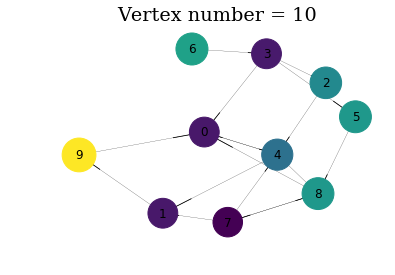

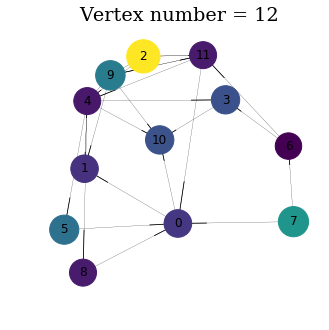

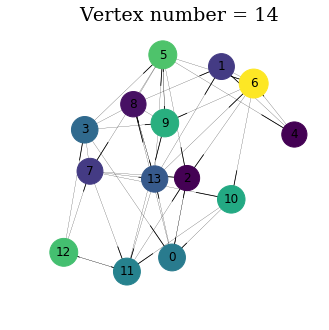

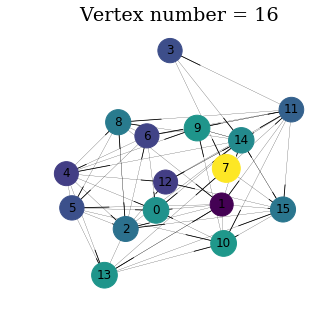

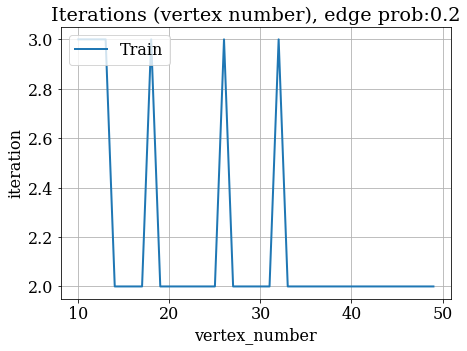

In [258]:
it_num = []
for v_num in vert_number:
    it_num.append(start_research(v_num, 0.2))
render_result_vert_num(it_num, vert_number, 0.2)

Сложно сказать о какой-то зависимости, видно, что когда было мало вершин, нужно было больше итерироваться

Попробуем проанализировать количество итераций от вероятности ребра

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


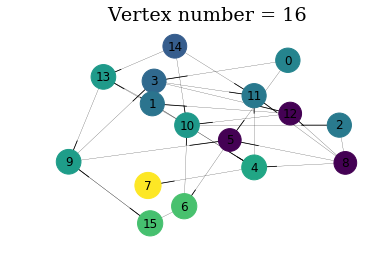

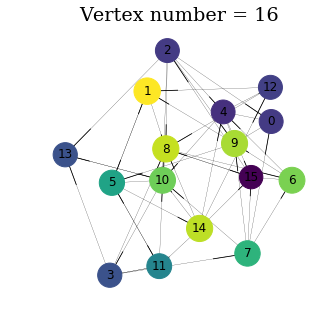

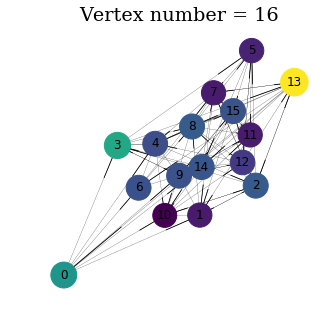

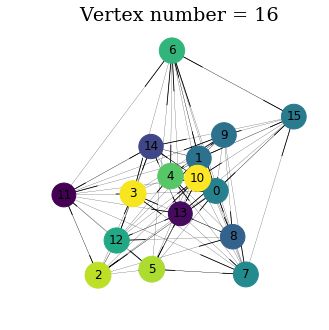

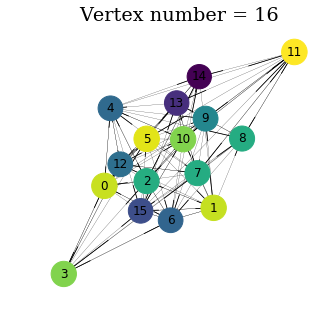

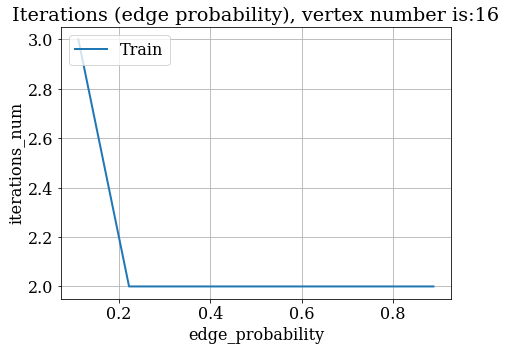

In [228]:
it_num = []
for edge_prob in edge_probability:
    it_num.append(start_research(16, edge_prob))
render_result_edge_prop(it_num, 16, edge_probability)

Чем больше вероятность возникновения ребра, тем меньше количество итераций, наше начальное приближение хорошо приближает такую ситуацию

Попробуем нарисовать для полносвязного графа

2

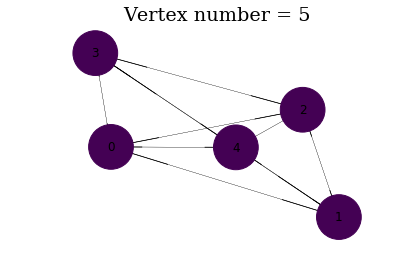

In [230]:
start_research(5, 1, exception_flag=True)

2

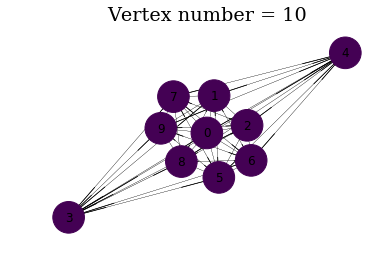

In [231]:
start_research(10, 1, exception_flag=True)

Для несвязного

In [264]:
print("iterations number {}".format(start_research(15, 0)))

iterations number 49


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Понятно, что наш алгоритм будет долго работать, потому что он изначально задаёт равноверноятное распределение, а нужно нулевое

Однако если будет минимальная связность, но большое количество вершин, алгоримт отработает хорошо. так как в целом количество вершин довольно большое, рёбер тоже получается достаточно

iterations number 2


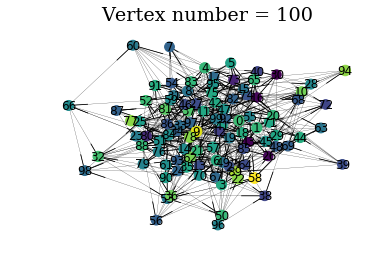

In [262]:
print("iterations number {}".format(start_research(100, 0.05, exception_flag=True)))

# Part 2 (15%)

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [265]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

___________________________________________________________________
Посчитаем pagerank для сайта разработки под android

In [266]:
urls = ['http://wikipedia.org/wiki/', 'https://developer.android.com/index.html']
site = get_site(urls[1])
links = []

N = 10
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

________________________________________________________________________________________
Преобразуем рёбра links, чтобы нумерация была с нуля

In [267]:
links = np.array(links)
links = np.apply_along_axis(lambda x: (x[0] - 1, x[1] - 1), 1, links)
print(len(links))

515


Постоим граф

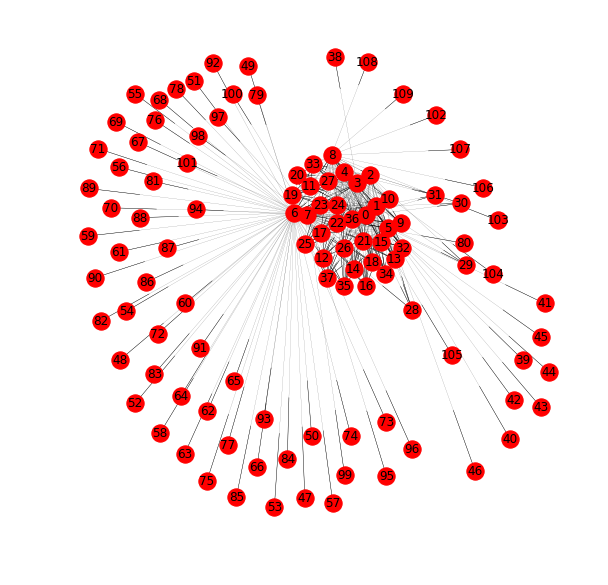

In [268]:
G = networkx.DiGraph()
plt.figure(figsize=(10, 10))
G.add_edges_from(links)
plt.axis('off')
networkx.draw_networkx(G, width=0.1)

А теперь с весами page_rank

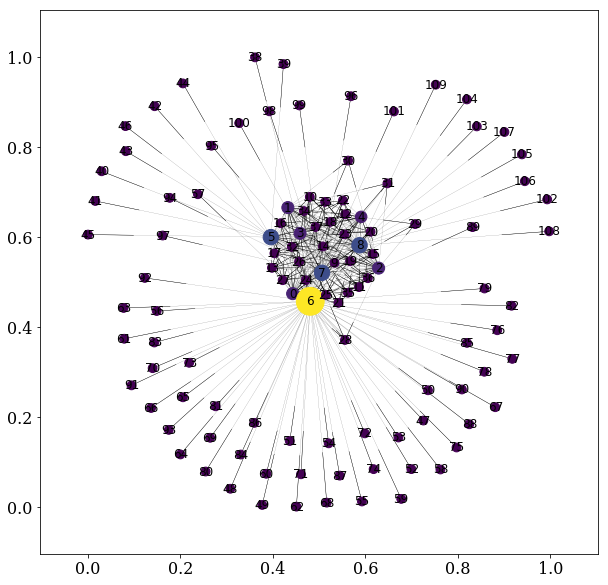

In [269]:
N = G.number_of_nodes()
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(links, start_distribution)
plt.figure(figsize=(10, 10))
networkx.draw_networkx(G, width=0.1, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Построим гистограмму весов, как видно из картинки, небольшое количество вершин, которые в центре, будут иметь большой pagerank, остальные не очень

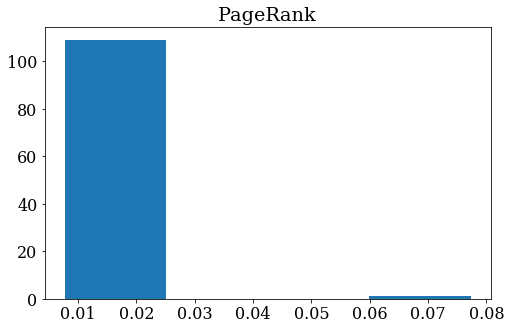

In [270]:
plt.figure(figsize=(8, 5))
plt.hist(pr_distribution, bins=4)
plt.title("PageRank")
plt.show()

Выделим подмножество вершин с наибольшим page rank, построим индуцированный подграфё

[3 1 2 0 7 8 5 6]


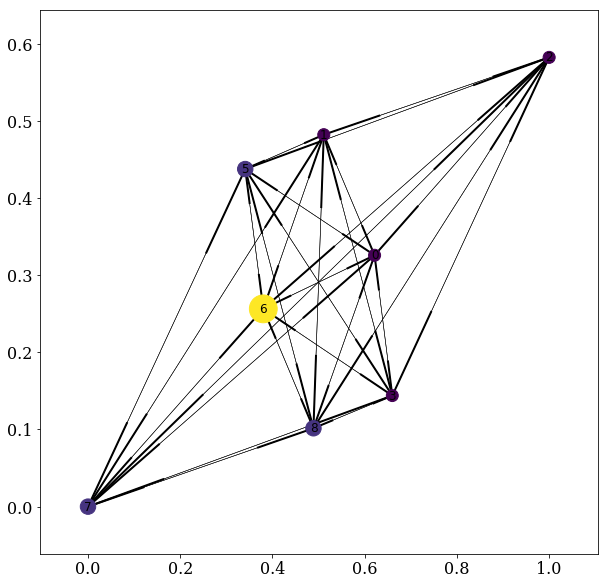

In [278]:
pages_ind = np.argsort(pr_distribution)[-8:]
print(pages_ind)
plt.figure(figsize=(10, 10))
networkx.draw_networkx(G.subgraph(pages_ind), width=0.5, node_size=size_const * pr_distribution[pages_ind], 
                       node_color=size_const * pr_distribution[pages_ind])

Видно, что наибольший page rank имеют страницы с маленькими индексами, если зайти на сайт developers.android, то видно, что это ссылки панели навигации, панель навигации остаётся для всех страниц общая, так что эти ссылки наиболее часто встречающиеся, остальные ссылки уже более узко специализированные. А седьмая, наиболее популярная ссылка ведёт на страницу About Android, что логично <b>:)</b>

## Part 3 (50%)

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.
Правда, привести файл к формату SVM-Rank (см. документацию по RankLib) придется самостоятельно.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [279]:
def read_metric_dependence_from_file(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        block_values = list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:index + num_lines]))
        values.append(block_values)
        text = text[index:]
        
    return values

In [280]:
def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[-1]))

            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[1:-2]:
                index, value = map(float, feat.split(':'))
                object_features[int(index)] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)

def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)

Прочитаем данные из файла

In [58]:
%%time
relevs, qids, features = read_file('./imat2009-datasets/imat2009_learning.txt', 250)

Воспльзуемся функцией, чтобы разделить данные

In [59]:
split_to_train_valid_test(relevs, qids, features,
                          './data/train.txt', './data/test.txt', 0.01, 0.01, 
                          valid_path='./data/valid.txt', valid_size=0.01)

Обучим lambdaMART

In [116]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 6 -tree 300 -metric2t NDCG -save ./model/log_LambdaMART > ./model/log_LambdaMART.txt

Wall time: 10.2 s


Обучим MART

In [115]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 0 -tree 300 -metric2t NDCG -save ./model/log_MART > ./model/log_MART.txt

Wall time: 8.15 s


Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

In [281]:
values = (read_metric_dependence_from_file('./model/log_LambdaMART.txt', 300)[0],
          read_metric_dependence_from_file('./model/log_MART.txt', 300)[0])


Функция построения графиков

In [299]:
def print_res_graph(alg_name, train, validation, trainLambda=None, validationLambda=None):
    plt.figure(figsize=(20, 8))
    plt.plot(range(len(train)), train, lw=2, label="Train")
    plt.plot(range(len(validation)), validation, lw=2, label="Validation")
    if (trainLambda):
        plt.plot(range(len(trainLambda)), trainLambda, lw=2, label="Train Lambda")
        plt.plot(range(len(validationLambda)), validationLambda, lw=2, label="Validation Lambda")
    plt.xlabel('iteration')
    plt.ylabel('NDCG')
    plt.title(alg_name)
    plt.legend(loc=2)
    plt.grid()
    plt.show()

Построим графики для LambdaMART и MART

In [300]:
trainLambda = [values[0][i][1] for i in range(len(values[0])) if values[0][i] != []]
validationLambda = [values[0][i][2] for i in range(len(values[0])) if values[0][i] != []]

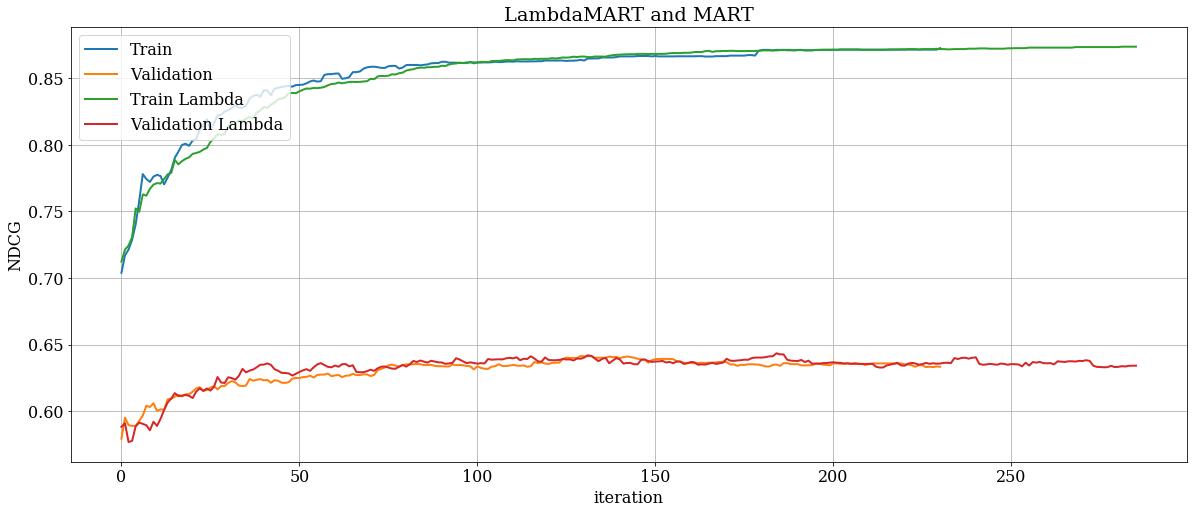

In [301]:
train = [values[1][i][1] for i in range(len(values[1])) if values[1][i] != []]
validation = [values[1][i][2] for i in range(len(values[1])) if values[1][i] != []]
print_res_graph("LambdaMART and MART", train, validation, trainLambda, validationLambda)

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

* Алгоритмы работают одинаково, видно, что на тренировочной выборке алгоритмы работают заметно лучше, чем на валидационной, значит, переобучаются

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

Для RankNet

In [ ]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 1 -layer 3 -node 30 -metric2t NDCG -save ./model/RankNet.txt > ./model/log_RankNet.txt

Wall time: 1min 7s


In [ ]:
values_RankNet = read_metric_dependence_from_file('./model/log_RankNet.txt', 300)[0]

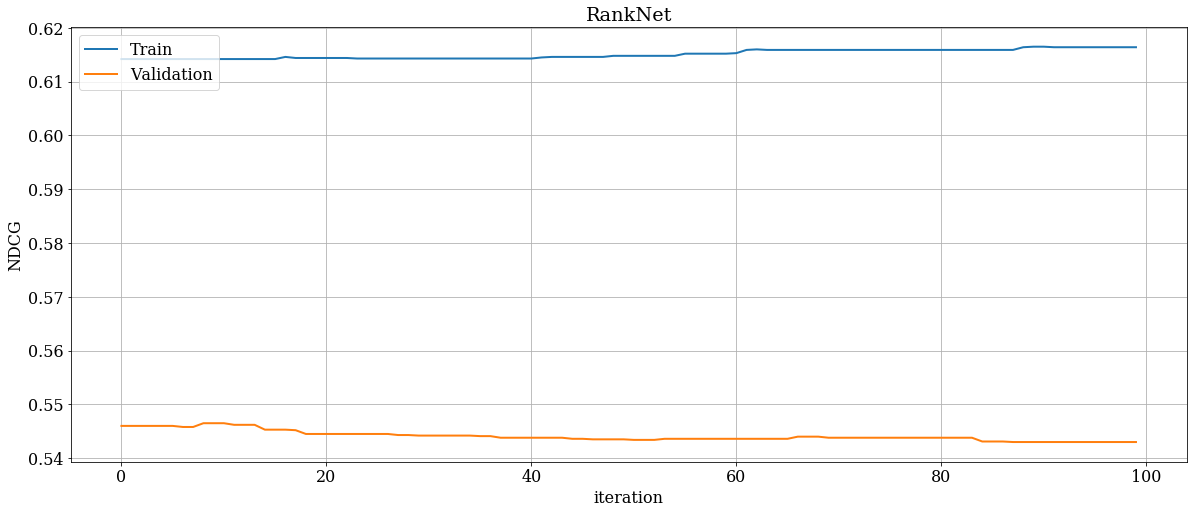

In [306]:
train = [values_RankNet[i][2] for i in range(len(values_RankNet)) if values_RankNet[i] != []]
validation = [values_RankNet[i][3] for i in range(len(values_RankNet)) if values_RankNet[i] != []]
# print(validation)
print_res_graph("RankNet", train, validation)

Работает хуже, чем LambdaMART и MART, также переобучается, но это возможно из-за небольшой выборки и неподходящих параметров

In [6]:
def read_metric_dependence_from_file_Random_Forest(file_name, num_lines, num_blocks=1):
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4

        block_values = list(map(lambda x: list(map(float, x.split('|')[1:-1]))[0], 
                                         text[index:index + num_lines]))
        values.append(block_values)
        text = text[index:]
        
    return values

In [18]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 8 -tree 15 -metric2t NDCG -save ./model/RandomForest.txt > ./model/log_RandomForest.txt

Wall time: 32.6 ms


Џа®жҐбб ­Ґ ¬®¦Ґв Ї®«гзЁвм ¤®бвгЇ Є д ©«г, в Є Є Є нв®в д ©« § ­пв ¤агЈЁ¬ Їа®жҐбб®¬.


In [22]:
values_RandomForest = read_metric_dependence_from_file_Random_Forest('./model/log_RandomForest.txt', 300)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


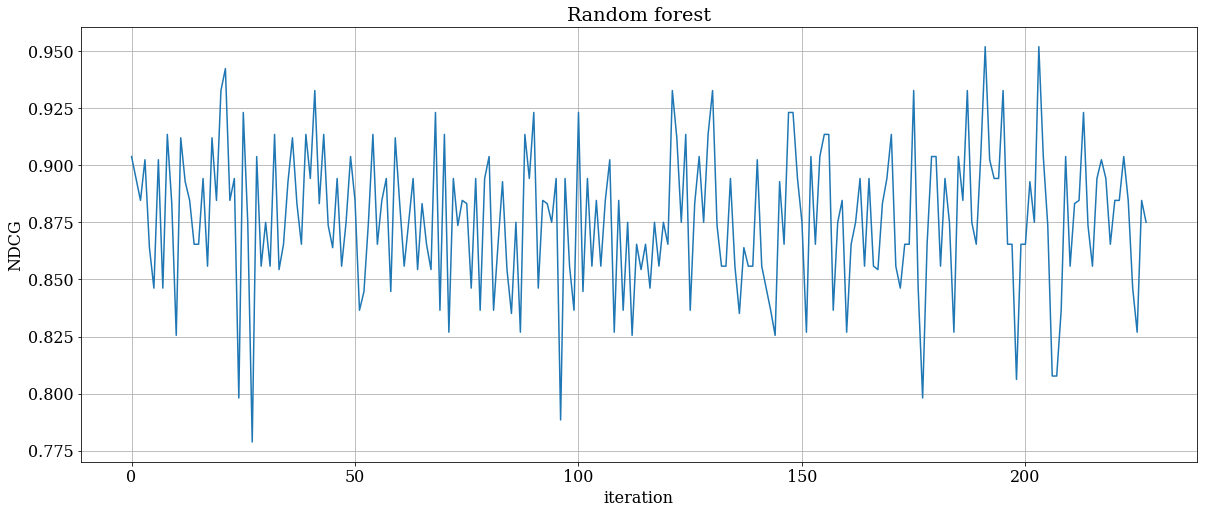

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(values_RandomForest[0])), values_RandomForest[0])
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('Random forest')
plt.legend(loc=2)
plt.grid()
plt.show()

Дисперсия уменьшается, чем больше подвыборок мы делаем